In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.optimizers import SGD, Adam

from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError
from utils.preprocess import *

In [2]:
print(tf.__version__)

# we need to set up gpus for tensorflow-gpu and cudnn
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)

tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Download, read in, preprocess data

In [3]:
model_prefix = ''
days = 7
regobs_types = list(REG_ENG.keys())
labeled_data = None
try:
    print("Reading csv")
    labeled_data = LabeledData.from_csv(days=days, regobs_types=regobs_types, with_varsom=False)
except CsvMissingError:
    print("Csv missing. Fetching online data. (This takes a long time.)")
    labeled_data = ForecastDataset(regobs_types=regobs_types).label(days=days, with_varsom=False)
    labeled_data.to_csv()

Reading csv


In [4]:
# read in data, extract data and labels
labeled_data = preprocess(labeled_data)
regions = labeled_data.data.reorder_levels([1, 0])
labels = labeled_data.label.reorder_levels([1, 0])

One of the first things we need to take care of is the precipitation column. There are some extremely high values throughout the dataset that we need to drop.

In [5]:
precip_cols = [col for col in regions.columns if 'precip' in col and 'exposed' not in col]
regions_precip = regions.loc[:, precip_cols]
regions_precip

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3031,2017-11-22,25.7,0.0,0.6,0.2,22.7,23.9
3034,2017-11-22,47.0,3.0,0.0,0.3,24.8,29.9
3031,2017-11-23,55.4,25.7,0.0,0.6,0.2,22.7
3034,2017-11-23,53.1,47.0,3.0,0.0,0.3,24.8
3007,2017-11-29,9.3,14.4,5.7,0.3,0.0,2.9
...,...,...,...,...,...,...,...
3031,2021-01-12,0.0,5.0,10.0,15.0,0.0,0.0
3032,2021-01-12,0.0,0.0,3.0,2.0,0.0,0.0
3034,2021-01-12,0.0,4.0,12.0,10.0,0.0,0.0


In [6]:
precip_outliers = np.where(regions_precip > 100)[0]
regions_precip.iloc[precip_outliers].head(50)

,,precip_0,precip_1,precip_2,precip_3,precip_4,precip_5
region,date,,,,,,
3006,2020-04-30,6280.500,0.000,0.1,0.3,0.900,1.700
3007,2020-04-30,6280.500,0.000,0.0,0.2,1.300,1.500
3009,2020-04-30,6280.900,0.000,0.0,0.3,1.200,1.600
3010,2020-04-30,6280.500,0.000,0.0,0.2,1.100,2.200
3011,2020-04-30,6280.500,0.000,0.0,0.0,0.700,1.000
3012,2020-04-30,6280.500,0.000,0.0,0.0,0.300,0.700
3013,2020-04-30,6280.858,0.000,0.0,0.1,0.600,1.100
3014,2020-04-30,6280.500,0.000,0.0,0.0,0.200,0.100
3015,2020-04-30,6280.500,0.000,0.0,0.0,0.700,1.100


In [7]:
drop_idx = regions.index[precip_outliers]
regions = regions.drop(drop_idx)
regions

,,precip_most_exposed_0,precip_most_exposed_1,precip_most_exposed_2,precip_most_exposed_3,precip_most_exposed_4,precip_most_exposed_5,precip_0,precip_1,precip_2,precip_3,...,regobs_snowprofile_t_min_4_4,regobs_snowprofile_t_min_4_5,regobs_snowprofile_t_min_4_6,regobs_snowprofile_t_min_4_7,accuracy_2,accuracy_3,accuracy_4,accuracy_5,accuracy_6,accuracy_7
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-22,35.75,0.60,1.3,0.4,27.6,29.2,25.7,0.0,0.6,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-22,56.40,4.90,0.0,0.3,28.8,36.0,47.0,3.0,0.0,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3031,2017-11-23,79.70,35.75,0.6,1.3,0.4,27.6,55.4,25.7,0.0,0.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,65.90,56.40,4.9,0.0,0.3,28.8,53.1,47.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-11-29,9.70,16.90,7.2,0.7,0.0,3.4,9.3,14.4,5.7,0.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,0.00,10.00,15.0,20.0,2.0,0.0,0.0,5.0,10.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,0.00,2.00,6.0,5.0,0.0,0.0,0.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,2.00,8.00,20.0,20.0,0.0,0.0,0.0,4.0,12.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
regions.loc[:, precip_cols].max()

precip_0    95.6
precip_1    95.6
precip_2    95.6
precip_3    95.6
precip_4    95.6
precip_5    95.6
dtype: float64

These seem like more reasonable values.

In [9]:
# encode cause and aspect columns in labels
labels = encode_causes(labels)
labels = encode_aspects(labels)

In [10]:
def wind_speed_max(df, col_list):
    """
    Create wind_speed_max_# columns from wind_speed_# and wind_change_speed_#
    input columns. This will drop the wind_speed_# and wind_change_speed_# columns.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for the wind_speed_# and wind_change_speed_# features
    
    Returns:
        df(DataFrame): same input data frame with new wind_speed_max_# columns
    """
    # so there is a wind_speed and wind_change_speed column for each day
    # that means that there are len(col_list) / 2 unique days
    for day in range(int(len(col_list) / 2)):
        speed_col = 'wind_speed_' + str(day)
        change_col = 'wind_change_speed_' + str(day)
        max_col = 'wind_speed_max_' +str(day)
        
        # take the max over rows
        df[max_col] = df.loc[:, [speed_col, change_col]].max(axis=1)
        
    # drop unwanted wind columns
    df.drop(col_list, axis=1, inplace=True)
    return df

In [11]:
def sum_over_features(df, col_list, new_name, drop=False):
    """
    Create column for maximum wind speed over the past 72 hours.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for a set of features; this could be wind, precip, etc.
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
        
    NOTE: You need to make sure you pass in intelligible columns. For instance, it may not make sense to
          sum over certain columns. Additionally, all of the input columns should follow the same
          naming convection, i.e., `precip_0`, `precip_`, `precip_3`
    
    Returns:
        df(DataFrame): same input dataframe with summed column, after dropping input columns
    """
    # sum over rows, or each day
    df[new_name] = df.loc[:, col_list].sum(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [12]:
def take_max(df, col_list, new_name, drop=False):
    """
    Create a column for the max value given over the past 3 days (72 hours).
    This will drop the input columns in col_list if drop is set to True.
    
    Arguments:
        df(DataFrame): the input dataframe containing our RegObs observations
        col_list(list): a list of columns for creating the max value
        new_name(str): what you want the new column name to be
        drop(bool): whether to drop the columns in col_list before returning df
    
    Returns:
        df(DataFrame): same input data frame with new max value column
    """
    # take the max over rows
    df[new_name] = df.loc[:, col_list].max(axis=1)
    
    # drop unwanted columns
    if drop == True:
        df.drop(col_list, axis=1, inplace=True)
    
    return df

In [13]:
# drop wind speed columns
wind_dir_cols = [col for col in regions.columns if 'wind_dir' in col]
regions.drop(wind_dir_cols, axis=1, inplace=True)

# create 72 hour sum or max of wind speed, precip, and max temp
wind_speed_cols = [col for col in regions.columns if 'wind' in col and 'speed' in col]
regions = wind_speed_max(regions, wind_speed_cols)
to_sum = ['wind_speed_max_0', 'wind_speed_max_1', 'wind_speed_max_2']
regions = sum_over_features(regions, to_sum, 'wind_speed_72hr')

to_sum = ['precip_0', 'precip_1', 'precip_2']
regions = sum_over_features(regions, to_sum, 'precip_72hr')

to_sum = ['temp_max_0', 'temp_max_1', 'temp_max_2']
regions = take_max(regions, to_sum, 'temp_max_72hr')

In [14]:
max_sum_cols = [col for col in regions.columns if '72hr' in col]
train = regions.loc[:, max_sum_cols]
train

,,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,
3031,2017-11-22,24.0,26.3,-3.5
3034,2017-11-22,33.0,50.0,-2.0
3031,2017-11-23,39.5,81.1,3.0
3034,2017-11-23,46.0,103.1,3.0
3007,2017-11-29,29.5,29.4,-4.1
...,...,...,...,...
3031,2021-01-12,20.0,15.0,-5.0
3032,2021-01-12,26.5,3.0,-9.0
3034,2021-01-12,23.5,16.0,-7.0


In [15]:
def scale_input_data(X):
    """
    Scale input features from [-1, 1] so that it is easier to
    train a neural network.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(X)
    return scaled

In [16]:
scaled_X = scale_input_data(train.values)
train = pd.DataFrame(scaled_X, columns=train.columns, index=train.index)
train

,,wind_speed_72hr,precip_72hr,temp_max_72hr
region,date,,,
3031,2017-11-22,-0.421687,-0.655721,-0.057781
3034,2017-11-22,-0.204819,-0.345477,0.008330
3031,2017-11-23,-0.048193,0.061636,0.228701
3034,2017-11-23,0.108434,0.349627,0.228701
3007,2017-11-29,-0.289157,-0.615140,-0.084226
...,...,...,...,...
3031,2021-01-12,-0.518072,-0.803643,-0.123893
3032,2021-01-12,-0.361446,-0.960729,-0.300190
3034,2021-01-12,-0.433735,-0.790553,-0.212041


In [17]:
print(np.any(np.isnan(train)))

False


In [18]:
# could use CLASS_danger_level or CLASS_problem_1
train_labels = labels.loc[:, ['CLASS_danger_level']]
train_labels

,,CLASS_danger_level
region,date,
3031,2017-11-22,4
3034,2017-11-22,4
3031,2017-11-23,4
3034,2017-11-23,4
3007,2017-11-29,3
...,...,...
3031,2021-01-12,3
3032,2021-01-12,3
3034,2021-01-12,3


# Split data

In [19]:
train_idx = [3007, 3012, 3010, 3009, 3013, 3017, 3014, 3032, 
             3027, 3029, 3022, 3031, 3023, 3037, 3024, 3028]
val_idx =   [3011, 3016, 3035]
test_idx =  [3006, 3015, 3034]

X_train = [train.loc[idx].values for idx in train_idx]
y_train = [train_labels.loc[idx].values for idx in train_idx]

X_val = [train.loc[idx].values for idx in val_idx]
y_val = [train_labels.loc[idx].values for idx in val_idx]

X_test = [train.loc[idx].values for idx in test_idx]
y_test = [train_labels.loc[idx].values for idx in test_idx]

In [20]:
print(np.any(np.isnan(np.concatenate(X_train))))

False


In [21]:
for arr in X_train:
    print(arr.shape)

(594, 3)
(594, 3)
(594, 3)
(594, 3)
(593, 3)
(593, 3)
(593, 3)
(593, 3)
(593, 3)
(593, 3)
(593, 3)
(595, 3)
(593, 3)
(341, 3)
(593, 3)
(593, 3)


In [22]:
plotx = X_train[0]
ploty = y_train[0]
wind = plotx[:, 0]
temp = plotx[:, 2] 
precip = plotx[:, 1]

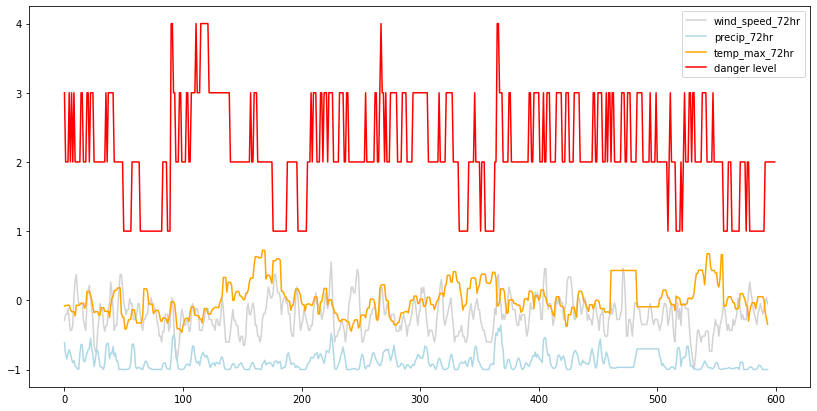

In [23]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(wind, color='lightgrey', label='wind_speed_72hr')
ax.plot(precip, color='lightblue', label='precip_72hr')
ax.plot(temp, color='orange', label='temp_max_72hr')
ax.plot(ploty, color='r', label='danger level')

ax.legend()
plt.show()

I should generalize the normalization process for input variables for X_train, X_val, and X_test (over each column).

In [24]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(594, 3) (600, 1)
(594, 3) (600, 1)
(594, 3) (600, 1)
(594, 3) (600, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)
(595, 3) (601, 1)
(593, 3) (599, 1)
(341, 3) (347, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)


In [25]:
for (arr, label) in zip(X_val, y_val):
    print(arr.shape, label.shape)

(594, 3) (600, 1)
(593, 3) (599, 1)
(593, 3) (599, 1)


In [26]:
for (arr, label) in zip(X_test, y_test):
    print(arr.shape, label.shape)

(174, 3) (180, 1)
(592, 3) (598, 1)
(595, 3) (601, 1)


In [27]:
def pad_sequence(arr, length):
    """
    This method will pad a m x n array so that m is perfectly
    divisible by length. That is, m % length == 0.
    
    Arguments:
        arr(array): m x n array where there are n input features of length m
        length(int): what we want the length of of arr to be divisible by
        
    Returns:
        padded(array): new padded array
    """
    n_features = arr.shape[1]
    remainder = arr.shape[0] % length
    if remainder == 0: # then nothing to pad
        return arr
    
    pad_length = length - remainder
    to_add = np.zeros((pad_length, n_features))
    padded = np.concatenate([arr, to_add])
    #padded = np.concatenate([to_add, arr])
    
    return padded

**Maybe instead of padding, we should cut off data where it doesn't fit into full batches?**

In [28]:
sequence_length = 8
X_train = [pad_sequence(arr, sequence_length) for arr in X_train]
y_train = [pad_sequence(arr, sequence_length) for arr in y_train]

X_val = [pad_sequence(arr, sequence_length) for arr in X_val]
y_val = [pad_sequence(arr, sequence_length) for arr in y_val]

X_test = [pad_sequence(arr, sequence_length) for arr in X_test]
y_test = [pad_sequence(arr, sequence_length) for arr in y_test]

In [29]:
for (arr, label) in zip(X_train, y_train):
    print(arr.shape, label.shape)

(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)
(600, 3) (608, 1)
(600, 3) (600, 1)
(344, 3) (352, 1)
(600, 3) (600, 1)
(600, 3) (600, 1)


### Creating a windowed dataset
- https://curiousily.com/posts/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python/
- https://stackoverflow.com/questions/45435049/lstm-understand-timesteps-samples-and-features-and-especially-the-use-in-resha
- https://stackoverflow.com/questions/48491737/understanding-keras-lstms-role-of-batch-size-and-statefulness

Instead of jumping by `sequence_length` below, we need to shift by a certain amount every time. So use days 1-7 to predict day 8, days 2-8 to predict day 9, etc.

Then the labels should start by predicting day 8, 9, etc.

In [30]:
# reshape data into (samples, timesteps, features)
# https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/
X_concat_train = np.concatenate(X_train)
y_concat_train = np.concatenate(y_train)

X_concat_val = np.concatenate(X_val)
y_concat_val = np.concatenate(y_val)

print(X_concat_train.shape)
print(y_concat_train.shape)

print(X_concat_val.shape)
print(y_concat_val.shape)

(9344, 3)
(9360, 1)
(1800, 3)
(1800, 1)


In [31]:
def batch_data(x, y, length):
    """
    Batch the neural network data, creating a shifting window of data at each time step.
    """    
    #create empty lists to append to
    X, Y = [], []
    
    #iterate over dataset, looking at moving window of 1 timestep
    #need to length to prevent out of bounds errors
    for i in range(0, len(x)-length):
        x_batch = x[i:length+i]
        y_batch = y[length+i]
        
        #append batches to lists
        X.append(x_batch)
        Y.append(y_batch)
    
    #convert lists to numpy arrays before turning into torch tensors
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    print(X.shape, Y.shape)
    return X, Y

In [32]:
batchX_train, batchY_train = batch_data(X_concat_train, y_concat_train, sequence_length)
batchX_val, batchY_val = batch_data(X_concat_val, y_concat_val, sequence_length)

(9336, 8, 3) (9336, 1)
(1792, 8, 3) (1792, 1)


### Stop here.

One thing I can't quite wrap my head around yet is how to stop one region from bleeing into the next during training. So for example, you have regions A and B. Region A is of length 600, and region B is of length 344 (both being evenly divisible by 8). As you get near the end of of region A's data, you are at somepoint going to try to predict data at day n+1. That seems fine **until the moving window** moves slides from region A into region B.

I am not quite sure how to fix this just yet.

In [33]:
to_print = 10
print(y_concat_train[sequence_length:sequence_length+to_print], '\n')
for i in range(to_print):
    print(i, batchX_train[i], batchY_train[i], '\n')

[[3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [2.]
 [2.]] 

0 [[-0.28915663 -0.61514043 -0.08422584]
 [-0.20481928 -0.78269834 -0.07541099]
 [-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]] [3.] 

1 [[-0.20481928 -0.78269834 -0.07541099]
 [-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]
 [ 0.06024096 -0.87302252 -0.16355943]] [2.] 

2 [[-0.20481928 -0.84815065 -0.07100357]
 [-0.12048193 -0.76437169 -0.07100357]
 [-0.27710843 -0.71331889 -0.07100357]
 [-0.43373494 -0.76960788 -0.12830006]
 [-0.43373494 -0.8468416  -0.16355943]
 [-0.36144578 -0.90051249 -0.16355943]
 [ 0.06024096 -0.87302252 -0.16355943]
 [ 0.28915663 -0.9

In [34]:
print(np.any(np.isnan(batchX_train)))

False


## Training a neural network

### DNN

Next, we can define our neural network below. This is a multiclass classification problem, meaning that we need as many output units in the last layer as there are unique labels in our training set. It also means that we should use a softmax activation in the last layer and some form of categorical crossentropy as the loss function.

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

input_neurons = 100
output_neurons = len(np.unique(batchY_train))
batch_size = 8
drop = 0.25

timesteps = batchX_train.shape[1]
features = batchX_train.shape[2]

# design network
dnn = tf.keras.models.Sequential()
dnn.add(Dense(input_neurons, activation='relu', input_shape=(timesteps, features)))
dnn.add(Dropout(drop))
dnn.add(Dense(input_neurons, activation='relu'))
dnn.add(Dropout(drop))
dnn.add(tf.keras.layers.Flatten())
dnn.add(Dense(output_neurons, activation='softmax'))

dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8, 100)            400       
_________________________________________________________________
dropout (Dropout)            (None, 8, 100)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 8, 100)            10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 100)            0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 4005      
Total params: 14,505
Trainable params: 14,505
Non-trainable params: 0
____________________________________________________

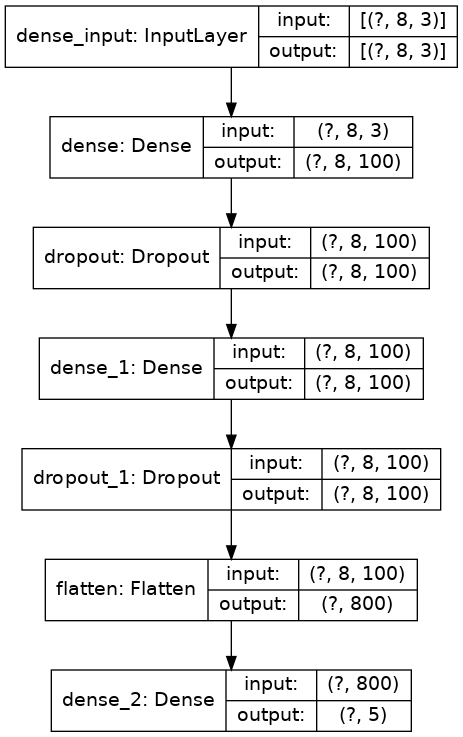

In [36]:
# being able to print model architectures in tensorflow is
# dependent on having pydot and graphviz packages installed
tf.keras.utils.plot_model(dnn, 'dnn_architecture.png', show_shapes=True)

Below, I have used sparse categorical crossentropy as my loss function instead of plain old categorical crossentropy. My understanding of why this is useful is that you don't need to one-hot encode your labels. So instead of having n-columns in your output labels for n labels, you can instead use a single vector (which is how our labels are formatted). Alongside that, you should use sparse categorical accuracy instead of accuracy in your reporting metrics.

In [37]:
# specify hyperparams here
num_epochs = 200
alpha = 1e-3
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)
#optimizer = tf.keras.optimizers.SGD(lr=0.0001)

# compile and fit model
dnn.compile(loss=criterion, 
              optimizer=optimizer, 
              metrics=['sparse_categorical_accuracy'])

dnn_history = dnn.fit(batchX_train, batchY_train, 
                      validation_data=(batchX_val, batchY_val),
                      epochs=num_epochs, verbose=2, shuffle=False)

Epoch 1/200
292/292 - 1s - loss: 1.1181 - sparse_categorical_accuracy: 0.5091 - val_loss: 1.1387 - val_sparse_categorical_accuracy: 0.5028
Epoch 2/200
292/292 - 1s - loss: 1.0728 - sparse_categorical_accuracy: 0.5244 - val_loss: 1.1091 - val_sparse_categorical_accuracy: 0.5022
Epoch 3/200
292/292 - 1s - loss: 1.0619 - sparse_categorical_accuracy: 0.5255 - val_loss: 1.0914 - val_sparse_categorical_accuracy: 0.5106
Epoch 4/200
292/292 - 1s - loss: 1.0515 - sparse_categorical_accuracy: 0.5296 - val_loss: 1.0757 - val_sparse_categorical_accuracy: 0.5167
Epoch 5/200
292/292 - 1s - loss: 1.0452 - sparse_categorical_accuracy: 0.5305 - val_loss: 1.0680 - val_sparse_categorical_accuracy: 0.5240
Epoch 6/200
292/292 - 1s - loss: 1.0379 - sparse_categorical_accuracy: 0.5334 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.5279
Epoch 7/200
292/292 - 1s - loss: 1.0307 - sparse_categorical_accuracy: 0.5376 - val_loss: 1.0482 - val_sparse_categorical_accuracy: 0.5285
Epoch 8/200
292/292 - 1s - 

Epoch 60/200
292/292 - 1s - loss: 0.9339 - sparse_categorical_accuracy: 0.5785 - val_loss: 0.9781 - val_sparse_categorical_accuracy: 0.5368
Epoch 61/200
292/292 - 1s - loss: 0.9328 - sparse_categorical_accuracy: 0.5750 - val_loss: 0.9784 - val_sparse_categorical_accuracy: 0.5407
Epoch 62/200
292/292 - 1s - loss: 0.9323 - sparse_categorical_accuracy: 0.5753 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.5391
Epoch 63/200
292/292 - 1s - loss: 0.9320 - sparse_categorical_accuracy: 0.5765 - val_loss: 0.9743 - val_sparse_categorical_accuracy: 0.5446
Epoch 64/200
292/292 - 1s - loss: 0.9327 - sparse_categorical_accuracy: 0.5753 - val_loss: 0.9803 - val_sparse_categorical_accuracy: 0.5379
Epoch 65/200
292/292 - 1s - loss: 0.9341 - sparse_categorical_accuracy: 0.5747 - val_loss: 0.9757 - val_sparse_categorical_accuracy: 0.5413
Epoch 66/200
292/292 - 1s - loss: 0.9285 - sparse_categorical_accuracy: 0.5712 - val_loss: 0.9842 - val_sparse_categorical_accuracy: 0.5368
Epoch 67/200
292/292

Epoch 119/200
292/292 - 1s - loss: 0.8998 - sparse_categorical_accuracy: 0.5921 - val_loss: 0.9519 - val_sparse_categorical_accuracy: 0.5647
Epoch 120/200
292/292 - 1s - loss: 0.8963 - sparse_categorical_accuracy: 0.5954 - val_loss: 0.9647 - val_sparse_categorical_accuracy: 0.5631
Epoch 121/200
292/292 - 1s - loss: 0.8961 - sparse_categorical_accuracy: 0.5944 - val_loss: 0.9525 - val_sparse_categorical_accuracy: 0.5670
Epoch 122/200
292/292 - 1s - loss: 0.8976 - sparse_categorical_accuracy: 0.5954 - val_loss: 0.9566 - val_sparse_categorical_accuracy: 0.5647
Epoch 123/200
292/292 - 1s - loss: 0.8995 - sparse_categorical_accuracy: 0.5923 - val_loss: 0.9568 - val_sparse_categorical_accuracy: 0.5692
Epoch 124/200
292/292 - 1s - loss: 0.8996 - sparse_categorical_accuracy: 0.5966 - val_loss: 0.9535 - val_sparse_categorical_accuracy: 0.5647
Epoch 125/200
292/292 - 1s - loss: 0.8950 - sparse_categorical_accuracy: 0.5953 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.5675
Epoch 126/200

Epoch 178/200
292/292 - 1s - loss: 0.8757 - sparse_categorical_accuracy: 0.6073 - val_loss: 0.9747 - val_sparse_categorical_accuracy: 0.5575
Epoch 179/200
292/292 - 1s - loss: 0.8825 - sparse_categorical_accuracy: 0.5991 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.5631
Epoch 180/200
292/292 - 1s - loss: 0.8743 - sparse_categorical_accuracy: 0.6059 - val_loss: 0.9714 - val_sparse_categorical_accuracy: 0.5541
Epoch 181/200
292/292 - 1s - loss: 0.8730 - sparse_categorical_accuracy: 0.6037 - val_loss: 0.9712 - val_sparse_categorical_accuracy: 0.5681
Epoch 182/200
292/292 - 1s - loss: 0.8818 - sparse_categorical_accuracy: 0.6044 - val_loss: 0.9577 - val_sparse_categorical_accuracy: 0.5675
Epoch 183/200
292/292 - 1s - loss: 0.8769 - sparse_categorical_accuracy: 0.6015 - val_loss: 0.9646 - val_sparse_categorical_accuracy: 0.5748
Epoch 184/200
292/292 - 1s - loss: 0.8695 - sparse_categorical_accuracy: 0.6073 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.5720
Epoch 185/200

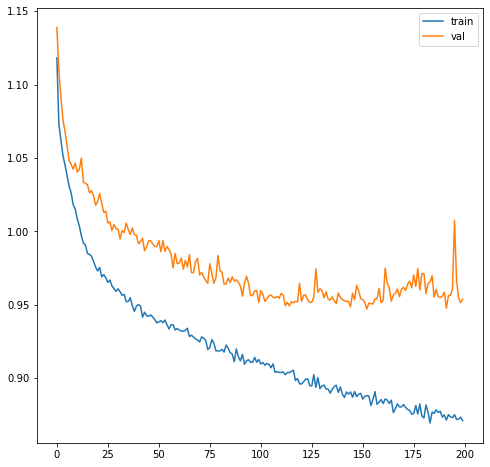

In [38]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(dnn_history.history['loss'], label='train')
ax.plot(dnn_history.history['val_loss'], label='val')

ax.legend()
plt.show()

We are now overfitting, but we were doing fine until epoch numer ~150. We could actually continue to run this network to improve the performance if we used some regularization. Both the training and validation loss are continuing to decrease. If regularization makes it so that we are underfitting again, we could then train for longer or train a bigger neural network.

Reference: https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

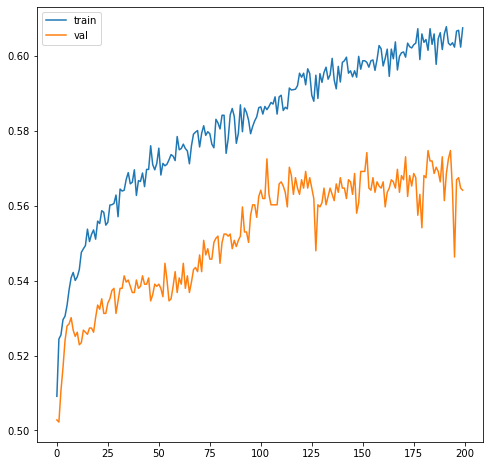

In [39]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(dnn_history.history['sparse_categorical_accuracy'], label='train')
ax.plot(dnn_history.history['val_sparse_categorical_accuracy'], label='val')

ax.legend()
plt.show()

This is not that great of accuracy. I think this is partly due to the data-windowing issue.

### LSTM

We can repeat the same steps as above, but this time with a LSTM to see how that affects performance.

In [41]:
input_neurons = 64
output_neurons = len(np.unique(batchY_train))
batch_size = 8
drop = 0.25

timesteps = batchX_train.shape[1]
features = batchX_train.shape[2]

# design network
model = tf.keras.models.Sequential()
model.add(LSTM(input_neurons, input_shape=(timesteps, features)))
model.add(Dense(input_neurons, activation='relu'))
model.add(Dropout(drop))
model.add(Dense(output_neurons, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 21,893
Trainable params: 21,893
Non-trainable params: 0
_________________________________________________________________


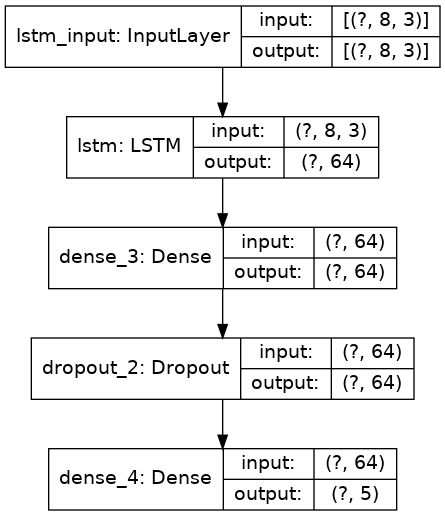

In [42]:
tf.keras.utils.plot_model(model, 'lstm_architecture.png', show_shapes=True)

In [43]:
# specify hyperparams here
num_epochs = 100
alpha = 1e-3
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(lr=alpha)

# compile and fit model
model.compile(loss=criterion, 
              optimizer=optimizer, 
              metrics=['sparse_categorical_accuracy'])

history = model.fit(batchX_train, batchY_train, 
                    validation_data=(batchX_val, batchY_val),
                    epochs=num_epochs, verbose=2, shuffle=False)

Epoch 1/100
292/292 - 1s - loss: 1.1568 - sparse_categorical_accuracy: 0.5108 - val_loss: 1.1712 - val_sparse_categorical_accuracy: 0.4955
Epoch 2/100
292/292 - 1s - loss: 1.1025 - sparse_categorical_accuracy: 0.5129 - val_loss: 1.1481 - val_sparse_categorical_accuracy: 0.4955
Epoch 3/100
292/292 - 1s - loss: 1.0862 - sparse_categorical_accuracy: 0.5124 - val_loss: 1.1358 - val_sparse_categorical_accuracy: 0.4972
Epoch 4/100
292/292 - 1s - loss: 1.0819 - sparse_categorical_accuracy: 0.5145 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.5061
Epoch 5/100
292/292 - 1s - loss: 1.0739 - sparse_categorical_accuracy: 0.5202 - val_loss: 1.1063 - val_sparse_categorical_accuracy: 0.5089
Epoch 6/100
292/292 - 1s - loss: 1.0678 - sparse_categorical_accuracy: 0.5183 - val_loss: 1.0862 - val_sparse_categorical_accuracy: 0.5084
Epoch 7/100
292/292 - 1s - loss: 1.0614 - sparse_categorical_accuracy: 0.5207 - val_loss: 1.0785 - val_sparse_categorical_accuracy: 0.5095
Epoch 8/100
292/292 - 1s - 

Epoch 60/100
292/292 - 1s - loss: 0.9229 - sparse_categorical_accuracy: 0.5798 - val_loss: 0.9820 - val_sparse_categorical_accuracy: 0.5352
Epoch 61/100
292/292 - 1s - loss: 0.9224 - sparse_categorical_accuracy: 0.5779 - val_loss: 0.9731 - val_sparse_categorical_accuracy: 0.5391
Epoch 62/100
292/292 - 1s - loss: 0.9180 - sparse_categorical_accuracy: 0.5789 - val_loss: 0.9775 - val_sparse_categorical_accuracy: 0.5352
Epoch 63/100
292/292 - 1s - loss: 0.9154 - sparse_categorical_accuracy: 0.5804 - val_loss: 0.9749 - val_sparse_categorical_accuracy: 0.5368
Epoch 64/100
292/292 - 1s - loss: 0.9112 - sparse_categorical_accuracy: 0.5833 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.5374
Epoch 65/100
292/292 - 1s - loss: 0.9058 - sparse_categorical_accuracy: 0.5855 - val_loss: 0.9770 - val_sparse_categorical_accuracy: 0.5413
Epoch 66/100
292/292 - 1s - loss: 0.9062 - sparse_categorical_accuracy: 0.5831 - val_loss: 0.9695 - val_sparse_categorical_accuracy: 0.5419
Epoch 67/100
292/292

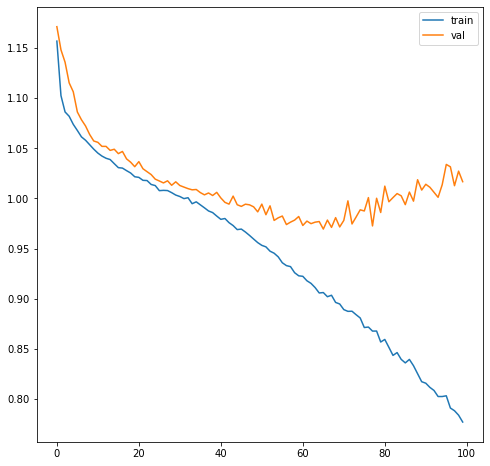

In [44]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')

ax.legend()
plt.show()

This looks like a classic case of [overfitting](https://en.wikipedia.org/wiki/Overfitting). Our validation loss starts increasing and our training loss continues decreasing. We could try to fix this with trying to add regularization to our network, or using a different architecture (maybe with less layers or neurons per layer).

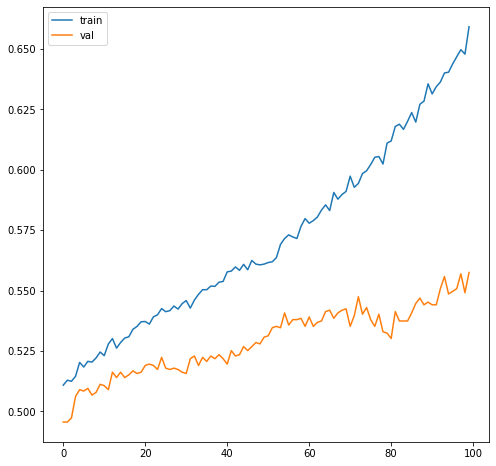

In [45]:
# plot history
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(history.history['sparse_categorical_accuracy'], label='train')
ax.plot(history.history['val_sparse_categorical_accuracy'], label='val')

ax.legend()
plt.show()

## Thoughts
- What would happen if we didn't use a sliding window for the input data? So instead of having (n\*window_size, window_size, features) you would have data with shape (n, 1, features). A DNN might be able to predict classes better this way, and it would solve the data-blending issue discussed above. You would then have to get the data like so:
```python
for each array in input data list
    X_train = X_train[:, :-1]
    # because we want to be able to predict the next day's
    # danger level, avlanche problem, etc.
    y_train = y_train[1:]
```
Then we could concatenate the data without worrying about blending different regions together. And that is what this tutorial shows: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

At least in the DNN case, we could even shuffle the data.